Below is an image of some neural tissue that has been stained for c-fos (in the 'Read in the image' section). One common task is to count how many neurons have this label. 

The manual methods are obvious but the computational methods need some framing. To achieve this, I have broken out the program into a few steps with headers below. At a high level, the main goal here is to simply take an image and provide an accurate guess as to how many objects are in it. To do so, we must 1) read in the image 2) pre-process the image 3) construct a model and 4) evaluate the model. 

# Read in the image

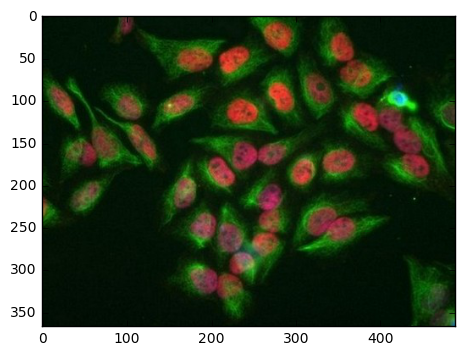

In [21]:
import numpy as np
import pylab
import mahotas as mh

#Read image
im = mh.imread( 'c_fos.jpg' )
pylab.imshow(im)
pylab.show()

It's kind of hard to determine from this image how many cells are labeled. As such, we may want to apply some filters before we go through and count up the correct number of cells to compare against what the program can do.

# Pre-Process

The structure of the file that we imported is a stack of 3 matrices where each matrix represent values for red, green, or blue. As the stain that we are interested in is red, we can simply filter the image to just be the red layer.

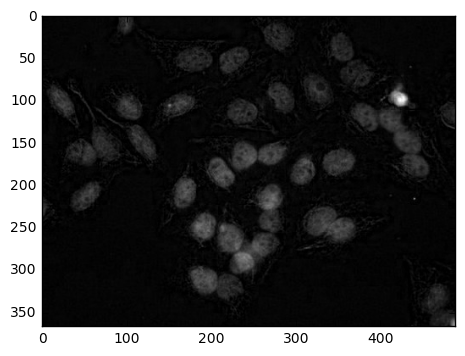

In [66]:
im_red = im[:,:,2]
imshow(im_red)
show()

Awesome. That does a great job of isolating the cells we're interested in. I am now going to count the cells and see how long it takes me. Here goes...

Cool. That took me ~30 seconds and I counted 36 cells. Let's see how well we can get a program to do the same thing.

# Build a Model

Admittedly, building a model requires more than what we have here. That is, you would need to have multiple images and preferably you'd have a lot. We just have one image so we really can't build a model but what we can do is establish the concept of what it means to make a prediction on a single image and, provided this framework, scale out and test with a larger sample later on.

## Model Basics

What do we want to estimate? In a simple way, we would like to just get the correct number of cells. A more complex approach would be to identify the spatial location as well. For now, though, let's just treat $Y$ as the correct number of cells and we are trying to find a $f(X)$ that accurately predicts $Y$. In this case, we have a two dimensional space and can treat an image as a density. That is, you can imagine a 2-d gaussian (bell curve) or a 3-d gaussian (bell curve shaped mountain). As such, we can treat the image as a density and simply try to find where these peaks occur (because presumably these are isolated cells).

## Gaussian Filtering

Arguably, this step could go into the pre-processing step. However, there's a parameter, $\Sigma$, that we toggle with here that could be used in developing one of the first models. In short, a Gaussian filter is a smoothing technique where you average a set of pixels together. The scope of this filtering is dictated by the variance ($Sigma$) assigned. For example, here's what the Gaussian filter looks like with low variance.

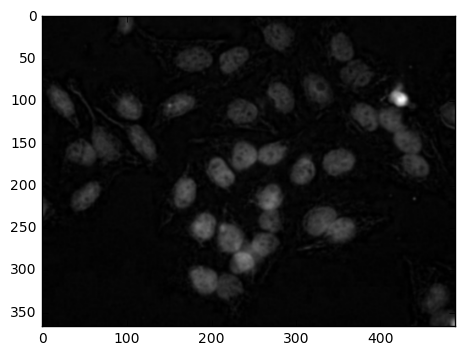

In [72]:
im_low = mh.gaussian_filter(im_red, 1)
imshow(im_low)
show()

Pretty much like the original image. Here's what the image looks when passed through a filter with a much higher variance.

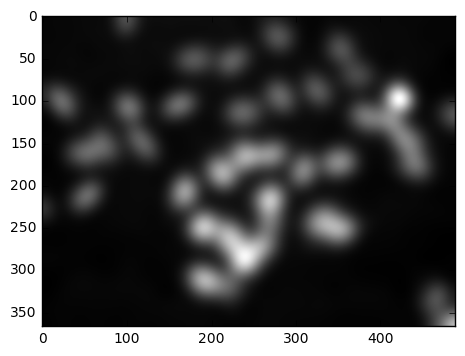

In [73]:
im_high = mh.gaussian_filter(im_red, 10)
imshow(im_high)
show()

A lot blurrier. Cool. So that's what a Gaussian filter does. 

## Dichotomous Filter with a Threshold
Now we want to take this Gaussian filter and set a reasonable threshold for making our image binary. A more difficult and complex model would simply use these smoothed out pixel values but we're going to start simple. The value that we use as a threshold is also a parameter that you can estimate. This will be important for later forming a probablistic model. The image below is one where we do a binary filter on the image that we've already done a Gaussian filter with at high variance. The binary filter simply takes numbers less than the mean pixel value and sets it to 0 and takes values greater than the mean pixel value and sets them to 1. 

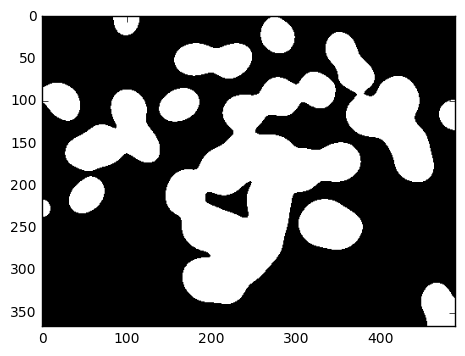

In [75]:
im_high_binary = (im_high > im_high.mean())
imshow(im_high_binary)
show()

## Connected component labelling
Or, as the lay-person calls it, blob extraction. This is where the actual counting of cells occurs. The basic method is to first find a pixel that has a signal (1 instead of a 0) and then find all the other pixels neighboring it and attach a label to it. You then perform this across the entire image and attaching new labels to the new blobs that you come across. This Python module has a super simple function to use called 'label' which achieves this for you.

In [76]:
labeled, n_labels = mh.label(im_high_binary)
print('Found {} labels.'.format(n_labels))

Found 13 labels.


Awesome. Well, kind of. Using this technique we were able to find 13 c-fos labelled cells. This is cool because it found some labelled cells but disappointing because it's wrong. Fortunately, we can take this kind of model, tune the parameters, and see about finding the optimal solution.

Found 36 nuclei.


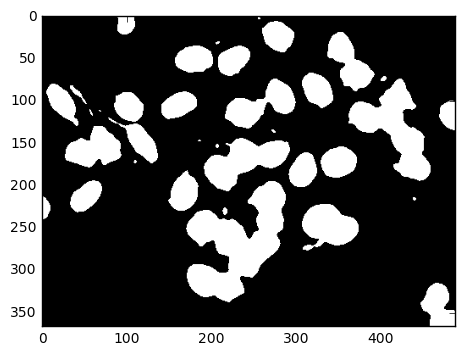

In [80]:
# I just toggled with the variance and got 2.7 as the sweet spot.
imf = mh.gaussian_filter(im_red, 2.7)

# I kept the transformed mean as the cut off. Again, this could be toggled with.
imf = (imf > imf.mean())

# Code below just displays outputs
labeled, n_nucleus  = mh.label(imf)
print('Found {} nuclei.'.format(n_nucleus))
imshow(imf)
show()

Cool. So with some manual toggling, you can get this program to correctly label the number of cells in the image. What we need to do now is to set up a learning framework so that this can scale. 

## The Cost Function
The most common approach is to set up a function that minimizes errors (or a cost function). This can be defined as:

\begin{align}
minimize \sum_{i=1}^{n}\big(Y_{i} - \hat{Y} \big)^2 \ or \\
minimize \sum_{i=1}^{n}\big(Y_{i} - f(X) \big)^2
\end{align}

in this case, $\hat{Y}$ is simply the estimated $Y$ value from a function on $X$ or $f(X)$. In this case, $X$ is actually a vector of three values, it's (X, Y) location as well as pixel value. This can be more formally defined as a two-dimensional density. As such, to build on this model, you'd want to explore two dimensional density functions to build smarter models.

# Evaluate the Model

Because we only have one labelled slide, we really can't do much in the way of an evaluation. That is, to effectively evaluate a model we'd want to break up our data into a 'training' and 'testing' set. The training set would be say 80% of a random sample from your data. Because we only have one observation, we cannot split it up. The other 20% of the data would be used to test out how your model did. Basically, you would make a prediction from your trained model onto your test data set and see how closely the values match. 

## Evaluating Time
One check we can do is with timing. Namely, I was able to manually score this slide in about 30 seconds. I can test how much faster a computer scores the slide. 

In [82]:
from time import time

# Get start time
start_time = time()

#Read image
im = mh.imread( 'c_fos.jpg' )

# Filter for just the red layer
im_red = im[:,:,2]

# Gaussian Filter
imf = mh.gaussian_filter(im_red, 2.7)

# Binary filter
imf = (imf > imf.mean())

# Get labels
labeled, n_nucleus  = mh.label(imf)

# Get end time
end_time = time()

# Get time delta
time_delta = end_time - start_time

# Print time it took
print('This took {} seconds.'.format(time_delta))

This took 0.03257393836975098 seconds.


Wow. That actually really impresses me. It took this program .04 seconds where it took me as an individual 30 seconds. That's close to a thousand times faster (750 times to be exact).

Anyway, that's all I got for now. It'd be fun to 1) get some more images and 2) try some smarter models.